In [261]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import generate_base_datasets
import pandas as pd
import numpy as np
import random
import json
import os

# Variável de desbalanceamento

Queremos testar os diversos indices de desbalanceamento (IR) do menor possível (1) até um número expressivo (140 no nosso caso), calculado como:

$IR = {M \over m}$

sendo $M$ a quantidade de entradas no dataset para classe majoritária e $m$ para a classe minoritária


Tendo em vista que o parâmetro relacionado a balanceamento no make_classificatin é em relação a porcentagem de uma das classes, ou seja calculado como

$Weight = {M \over M + m}$

assim, fazendo uma série de calculos simples podemos perceber que, para obter um IR de 1 é necessário que o peso de ambas as classes seja 0.5 (50%) e para o IR de 140 o peso da classe minoritária precisa ser de aproximadamente 0.007. E a diferença entre os pesos (ou o passo de incrementação ou decrementação é de aproximadamente 0.054)

In [262]:
START = 1
END = 141
STEP = 15.5

In [263]:
DATASETS_DIR = "datasets"
METADATAS_DIR = "metadatas"
PLOT_DIR = "plots"

In [264]:
random.seed(generate_base_datasets.RANDOM_STATE)

In [273]:
if not os.path.exists(DATASETS_DIR):
  os.mkdir(DATASETS_DIR)

if not os.path.exists(METADATAS_DIR):
  os.mkdir(METADATAS_DIR)

In [266]:
ratios = np.arange(START, END, STEP)
ratios

array([  1. ,  16.5,  32. ,  47.5,  63. ,  78.5,  94. , 109.5, 125. ,
       140.5])

In [267]:
def ratio_to_weight(ir):
  return 1/(ir + 1)

In [268]:
weights = list(map(ratio_to_weight, ratios))
weights

[np.float64(0.5),
 np.float64(0.05714285714285714),
 np.float64(0.030303030303030304),
 np.float64(0.020618556701030927),
 np.float64(0.015625),
 np.float64(0.012578616352201259),
 np.float64(0.010526315789473684),
 np.float64(0.00904977375565611),
 np.float64(0.007936507936507936),
 np.float64(0.007067137809187279)]

In [274]:
# generate datasets
parameters = generate_base_datasets.generate_parameters()
for i in range(len(parameters)):
  dataset_name = f"dataset_{i+1}"

  if not os.path.exists(os.path.join(DATASETS_DIR, dataset_name)):
    os.mkdir(os.path.join(DATASETS_DIR, dataset_name))

  with open(os.path.join(METADATAS_DIR, f"metadata_dataset_{i+1}.json"), 'w') as json_file:
    json.dump(parameters[i], json_file, indent=2)

  for weight in weights:
    parameters[i]["weights"] = [weight]
    X, y = make_classification(**parameters[i])
    dataset = pd.DataFrame(data=X)
    dataset['target'] = y
    dataset.to_csv(os.path.join(DATASETS_DIR, dataset_name, f"dataset_{i+1}_w_{weight:.3f}.csv"), index=False)
    

In [270]:
dataset_plots = []

for i in range(4):
  dataset_levels = []
  for w in weights:
    dataset_name = f"dataset_{i+1}"
    dataset_file = dataset_name + f"_w_{w:.3f}.csv"
    dataset = pd.read_csv(os.path.join(DATASETS_DIR, dataset_name, dataset_file))
    dataset_levels.append(dataset)
  dataset_plots.append(dataset_levels)

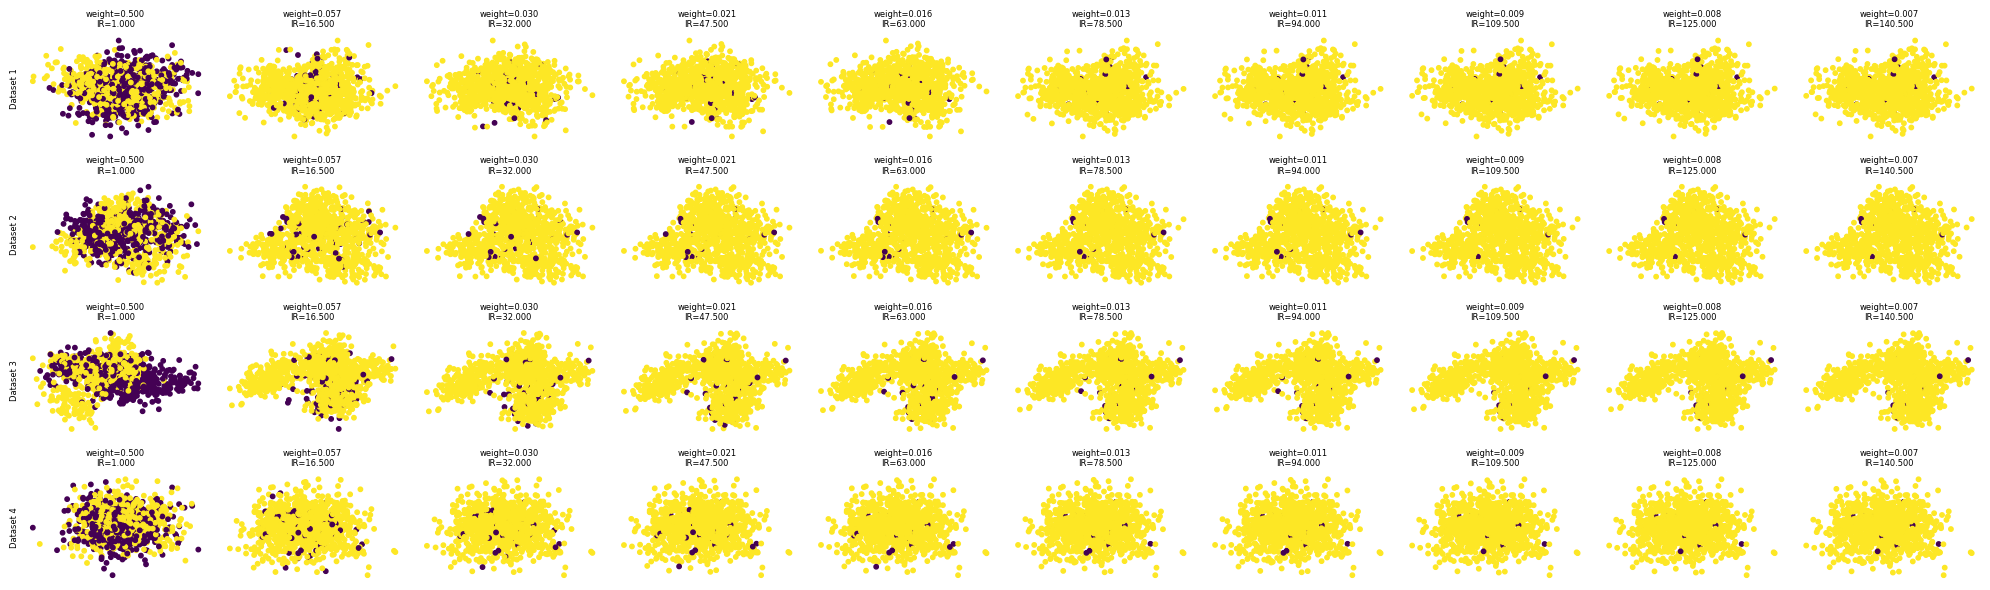

In [271]:
# Colocar labels

fig, axes = plt.subplots(4, 10, figsize=(20, 6))
axes = axes.flatten()
ax_idx = 0
pca = PCA(n_components=2)

for i in range(len(dataset_plots)):
  dataset = dataset_plots[i]
  axes[ax_idx].set_ylabel(f"Dataset {i+1}", fontsize=6)
  for j in range(len(weights)):
    X = dataset[j].iloc[:, :-1]
    y = dataset[j].iloc[:, -1]
    X_pca = pca.fit_transform(X)
    weight = weights[j]
    ir = (1/weight) - 1
    ax = axes[ax_idx]
    ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=10, cmap="viridis")
    ax.get_xaxis().set_visible(False)
    ax.set_yticks([])
    [spine.set_visible(False) for spine in ax.spines.values()]
    ax.set_title(f"weight={weight:.3f}\nIR={ir:.3f}", fontsize=6)
    ax_idx += 1

plt.tight_layout()
plt.savefig(os.path.join(PLOT_DIR, "imbalance_plot.png"))
plt.show()